In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from os.path import expanduser

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

from google.cloud import storage
from project_config import GCP_PROJECT_NAME, DATASET_JSON_PATH

from utils.visualizing import *

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

/home/gautamsai_y/.conda/envs/rv-21/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
from experiment_configs.test_config import *
config = test_config

In [3]:
from torch.utils.data import ConcatDataset
import json
from utils.rastervision_pipeline import observation_to_scene, scene_to_training_ds, scene_to_validation_ds, warn_if_nan_in_raw_raster
from utils.data_management import observation_factory

# get the current working directory
root_dir = os.getcwd()

# define the relative path to the dataset JSON file
json_rel_path = '../' + DATASET_JSON_PATH

# combine the root directory with the relative path
json_abs_path = os.path.join(root_dir, json_rel_path)

dataset_json = json.load(open(json_abs_path, 'r'))
all_observations = observation_factory(dataset_json)

training_scenes = []
validation_scenes = []

for observation in all_observations:

    if observation.cluster_id == 0: #statically assign clusetr zero to validation set
        validation_scenes.append(observation_to_scene(config, observation))
    else:
        training_scenes.append(observation_to_scene(config, observation))


training_datasets = [
    scene_to_training_ds(config, scene) for scene in training_scenes #random window sampling happens here
]
validation_datasets = [
    scene_to_validation_ds(config, scene) for scene in validation_scenes
]

train_dataset_merged = ConcatDataset(training_datasets[:10])
val_dataset_merged = ConcatDataset(validation_datasets[:10])


2023-12-20 08:23:34:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/s2/Bhargavi_Khordha_85-88_20-26_2018-12-01_s2.tif.
2023-12-20 08:23:34:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/s1/Bhargavi_Khordha_85-88_20-26_2018-12-01_s1.tif.
2023-12-20 08:23:34:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/annotations/Bhargavi_Khordha_85-88_20-26_2018-12-01_annotations_3class.geojson.
2023-12-20 08:23:34:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/rivers/Bhargavi_Khordha_85-88_20-26_rivers_1000m.g

In [25]:
ds = validation_datasets[0]
img = raster_source_to_rgb(ds.scene.raster_source)
labels_raster = ds.scene.label_source[:, :]

In [6]:
labels_raster.shape

(1231, 459)

In [13]:
df = ds.scene.label_source.raster_source.df

In [28]:
from rasterio.features import rasterize
from rastervision.core.box import Box

def geoms_to_conf_labels(df, window: 'Box',
                    background_class_id: int, all_touched: bool,
                    extent: 'Box') -> np.ndarray:
    """Rasterize geometries that intersect with the window."""
    if len(df) == 0:
        return np.full(window.size, background_class_id, dtype=np.float32)

    # subset to shapes that intersect window
    df_int = df.copy()
    # transform to window frame of reference
    shapes = df_int.translate(xoff=0, yoff=0)
    # confidence of each shape
    confidence_map = {"Low": 1, "High": 2}
    confidences = df_int["Confidence"].map(confidence_map)

    if len(shapes) > 0:
        rasters = []
        #iterate over each geometry in df_int, and rasterize it
        for i in range(len(df_int)):
            # print(i,shapes.iloc[i], class_ids.iloc[i])
            raster = rasterize(
                        shapes = [(shapes.iloc[i], confidences.iloc[i])],
                        out_shape = window.size,
                        fill = background_class_id,
                        all_touched=all_touched)
            # print(raster)
            rasters.append(raster)  
        #Now merge the rasters such that the maximum value is taken for each pixel
        return rasters
        # raster = np.maximum.reduce(rasters)

    else:
        raster = np.full(window.size, background_class_id)
    return raster

In [30]:
rasters = geoms_to_conf_labels(df, Box(0, 0, 1231, 459), 0, False, None)

In [41]:
low_conf = np.maximum.reduce([(r == 1) * 1 for r in rasters])
high_conf = np.maximum.reduce([(r == 2) * 2 for r in rasters])
overlaps = low_conf + high_conf

Text(0.5, 1.0, 'Highest Confidence Only')

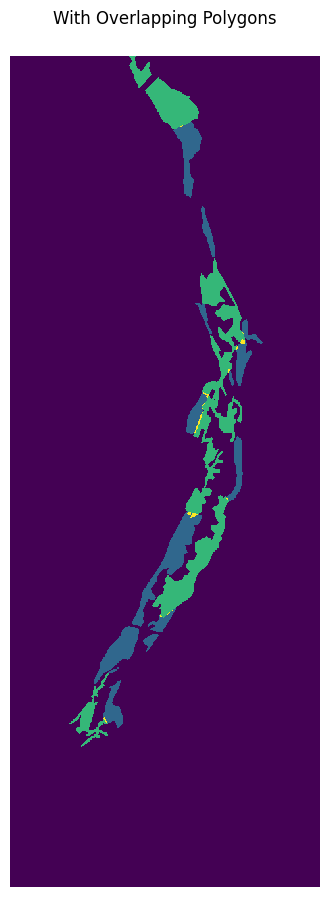

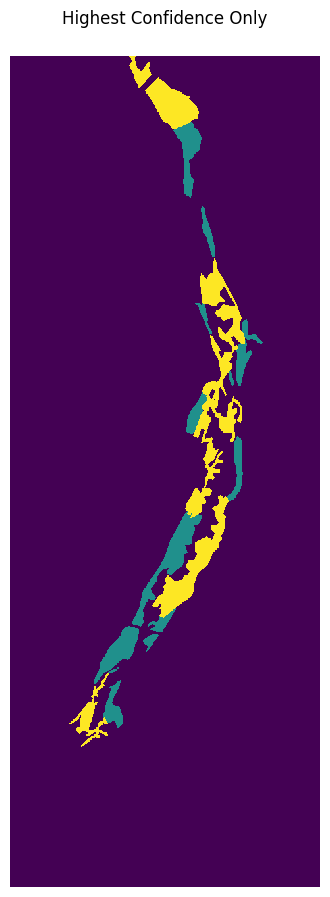

In [63]:
plt.matshow(overlaps)
plt.axis("off")
plt.title("With Overlapping Polygons")
plt.matshow(labels_raster)
plt.axis("off")
plt.title("Highest Confidence Only")

In [26]:
labels_raster.shape

(1231, 459)